In [1]:
import os
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import GlobalMaxPooling2D
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from PIL import Image

In [2]:
# Set working Dir
path = "D:\Python\Image-Recommendation"
os.chdir(path)
os.getcwd()

'D:\\Python\\Image-Recommendation'

In [32]:
df = pd.read_csv('Save-Dataset/product_data.csv')
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df.shape

(39194, 9)

In [33]:
train_df , test_df = train_test_split(df, test_size=0.25, stratify=df['category'])

print('Train-DF shape:', train_df.shape)
print('Test-DF shape:', test_df.shape)

Train-DF shape: (29395, 9)
Test-DF shape: (9799, 9)


In [35]:
train_df.to_csv('save-dataset/train.csv')
test_df.to_csv('save-dataset/test.csv')

In [34]:
train_df.head(5)

,product_id,asin,title,price,imUrl,brand,rating,filename,category
32535,32602,B00E9ZUIEU,Flat Fitty 5 Panel New School Snapback Cap,16.97,http://ecx.images-amazon.com/images/I/51Ttu2du...,Unknown,5.0,B00E9ZUIEU_51Ttu2duqyL._SX342_.jpg,Clothing Men
29458,29467,B00CA9HYSA,Swiss Precimax Men's SP13281 Pursuit Pro Sport...,87.18,http://ecx.images-amazon.com/images/I/516sRbyJ...,Swiss Precimax,5.0,B00CA9HYSA_516sRbyJaJL._SY300_.jpg,Watches
25127,25129,B009VSW01Y,Invicta Men's 12555 Pro Diver Ocean Ghost Blac...,99.99,http://ecx.images-amazon.com/images/I/51aV0YBV...,Invicta,5.0,B009VSW01Y_51aV0YBVRTL._SY300_.jpg,Watches
16429,16430,B005ZJQ8VG,3 Hoover Type W2 Windtunnel Allergy Vacuum Bag...,5.99,http://ecx.images-amazon.com/images/I/41Xlpn8j...,Hoover,5.0,B005ZJQ8VG_41Xlpn8jOTL._SY300_.jpg,Home and Kitchen
14967,14968,B005G8TZZC,4 Items Combo : Case - Screen Protector Film -...,2.58,http://ecx.images-amazon.com/images/I/41Jm1o0L...,Zizo,5.0,B005G8TZZC_41Jm1o0LMcL._SY300_.jpg,Cell Phones and Accessories


In [13]:
# Downlaod images for train data points(using id), run once
for idx, row in tqdm(train_df.iterrows()):    
    img = tf.keras.utils.load_img('Data\\Images\\Image_' + str(row['product_id'])+ '.jpeg')
    folder = path + '\\train-test-dataset\\train\\'+ row['category']
    isExist = os.path.exists(folder)
    if not isExist:
        # Create a new directory because it does not exist
        os.makedirs(folder)
        print("The new directory is created! Folder :" + folder )
    img.save( folder + '\\'+ str(row['product_id'])+'.jpeg')

6it [00:00, 55.96it/s]

The new directory is created! Folder :D:\Python\Image-Recommendation\train-test-dataset\train\Home and Kitchen
The new directory is created! Folder :D:\Python\Image-Recommendation\train-test-dataset\train\Shoes
The new directory is created! Folder :D:\Python\Image-Recommendation\train-test-dataset\train\Electronics
The new directory is created! Folder :D:\Python\Image-Recommendation\train-test-dataset\train\Pet Supplies
The new directory is created! Folder :D:\Python\Image-Recommendation\train-test-dataset\train\Watches
The new directory is created! Folder :D:\Python\Image-Recommendation\train-test-dataset\train\Cell Phones and Accessories
The new directory is created! Folder :D:\Python\Image-Recommendation\train-test-dataset\train\Clothing Women
The new directory is created! Folder :D:\Python\Image-Recommendation\train-test-dataset\train\Clothing Men


29395it [06:17, 77.81it/s] 


In [40]:
for idx, row in tqdm(test_df.iterrows()):    
    img = tf.keras.utils.load_img('Data\\Images\\Image_' + str(row['product_id'])+ '.jpeg')
    folder = path + '\\train-test-dataset\\test\\'+ row['category']
    isExist = os.path.exists(folder)
    if not isExist:
        # Create a new directory because it does not exist
        os.makedirs(folder)
        print("The new directory is created! Folder :" + folder )
    img.save( folder + '\\'+ str(row['product_id'])+'.jpeg')

5it [00:00,  8.39it/s]

The new directory is created! Folder :D:\Python\Image-Recommendation\train-test-dataset\test\Watches
The new directory is created! Folder :D:\Python\Image-Recommendation\train-test-dataset\test\Clothing Men
The new directory is created! Folder :D:\Python\Image-Recommendation\train-test-dataset\test\Pet Supplies
The new directory is created! Folder :D:\Python\Image-Recommendation\train-test-dataset\test\Clothing Women
The new directory is created! Folder :D:\Python\Image-Recommendation\train-test-dataset\test\Shoes
The new directory is created! Folder :D:\Python\Image-Recommendation\train-test-dataset\test\Electronics


19it [00:01, 24.51it/s]

The new directory is created! Folder :D:\Python\Image-Recommendation\train-test-dataset\test\Home and Kitchen
The new directory is created! Folder :D:\Python\Image-Recommendation\train-test-dataset\test\Cell Phones and Accessories


9799it [03:46, 43.31it/s]


In [14]:
folders = glob('train-test-dataset\\train\\*')
print(folders)

['train-test-dataset\\train\\Cell Phones and Accessories', 'train-test-dataset\\train\\Clothing Men', 'train-test-dataset\\train\\Clothing Women', 'train-test-dataset\\train\\Electronics', 'train-test-dataset\\train\\Home and Kitchen', 'train-test-dataset\\train\\Pet Supplies', 'train-test-dataset\\train\\Shoes', 'train-test-dataset\\train\\Watches']


In [15]:
IMAGE_SIZE = [224, 224]

In [16]:
# Add preprocessing layer to the front of ResNet50
resnet = ResNet50(weights='imagenet',include_top=False,input_shape=(224,224,3))
for layer in resnet.layers:
  layer.trainable = False

In [17]:
# our layers - you can add more if you want
x = Flatten()(resnet.output)
prediction = Dense(len(folders), activation='softmax')(x)

In [18]:
# create a model object
model = Model(inputs=resnet.input, outputs=prediction)

In [19]:
# view the structure of the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [20]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [21]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   validation_split=0.2)

In [23]:
training_set = train_datagen.flow_from_directory('train-test-dataset/train',                                                 
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',
                                                 subset='training',
                                                 shuffle=True,
                                                 seed=42)

Found 23517 images belonging to 8 classes.


In [24]:
validation_set = train_datagen.flow_from_directory('train-test-dataset/train',
                                                    target_size=(224, 224),
                                                    batch_size=32,
                                                    class_mode="categorical",
                                                    subset='validation',
                                                    shuffle=True,
                                                    seed=42)

Found 5878 images belonging to 8 classes.


In [41]:
test_datagen = ImageDataGenerator(rescale = 1./255)

In [42]:
testing_set = test_datagen.flow_from_directory('train-test-dataset/test',                                                 
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',                                                 
                                                 shuffle=True,
                                                 seed=42)

Found 9799 images belonging to 8 classes.


In [25]:
# fit the model
r = model.fit_generator(
  training_set,
  validation_data=validation_set,
  epochs=10,
  steps_per_epoch=len(training_set),
  validation_steps=len(validation_set)
)

C:\Users\Shashank\AppData\Local\Temp\ipykernel_21012\4186245597.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  r = model.fit_generator(


Epoch 1/10
735/735 [==============================] - 2713s 4s/step - loss: 2.2989 - accuracy: 0.4103 - val_loss: 1.9401 - val_accuracy: 0.4801
Epoch 2/10
735/735 [==============================] - 2693s 4s/step - loss: 2.1194 - accuracy: 0.4753 - val_loss: 2.4111 - val_accuracy: 0.4653
Epoch 3/10
735/735 [==============================] - 2683s 4s/step - loss: 1.9571 - accuracy: 0.5037 - val_loss: 1.9190 - val_accuracy: 0.4869
Epoch 4/10
735/735 [==============================] - 2715s 4s/step - loss: 1.9475 - accuracy: 0.5170 - val_loss: 1.8851 - val_accuracy: 0.4888
Epoch 5/10
735/735 [==============================] - 2729s 4s/step - loss: 1.9516 - accuracy: 0.5283 - val_loss: 3.1907 - val_accuracy: 0.4512
Epoch 6/10
735/735 [==============================] - 1951s 3s/step - loss: 1.8074 - accuracy: 0.5426 - val_loss: 2.8084 - val_accuracy: 0.4040
Epoch 7/10
735/735 [==============================] - 1859s 3s/step - loss: 1.8303 - accuracy: 0.5493 - val_loss: 2.2719 - val_accuracy:

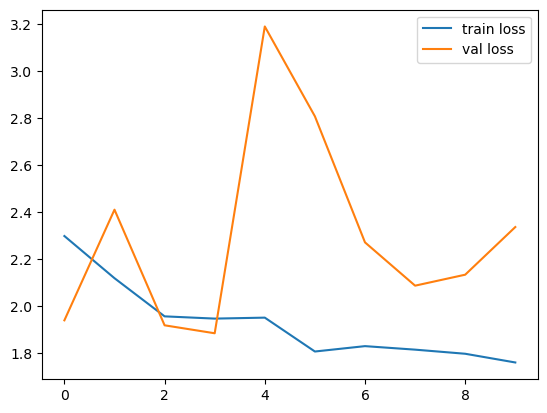

<Figure size 640x480 with 0 Axes>

In [28]:
# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

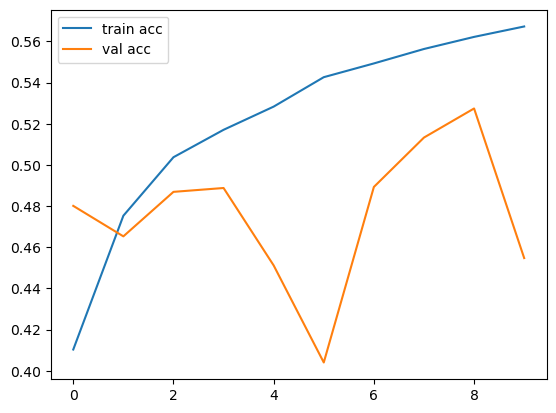

<Figure size 640x480 with 0 Axes>

In [27]:
# accuracies
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [39]:
print("Total Params:", model.count_params())

Total Params: 24390536


In [43]:
print("Accuracy : ", model.evaluate(testing_set))

307/307 [==============================] - 1743s 6s/step - loss: 2.0043 - accuracy: 0.5386
Accuracy :  [2.0043094158172607, 0.5386263728141785]


In [29]:
import tensorflow as tf

from keras.models import load_model

model.save('model/model_resnet50.h5')

---